[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GaoyuanWu/JaxSSO/blob/main/Examples/Arch_2D.ipynb)

In [ ]:
!pip install JaxSSO
!pip install nlopt

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import JaxSSO as sso #Sensitivity analysis solver
import jax
jax.config.update("jax_enable_x64", True)

# Define the objective function and the gradient of the objective

*   The geometry, mesh
*   Build the SSO model


Setup: the nodes, connectivity, the load, the element's properties

In [2]:
#Nodes
n_node = 21
x_span = 10
x_nodes = np.linspace(0,x_span,n_node)
y_nodes = np.zeros(n_node)
z_nodes = np.random.uniform(0,0.5,n_node)
z_nodes[0] = 0
z_nodes[n_node-1] = 0
design_nodes = np.array([i for i in range(n_node) if i!=0 and i!=n_node-1])
non_design_nodes = np.array([i for i in range(n_node) if i==0 or i==n_node-1])
#Connectivity
n_ele = n_node -1 #number of elements
cnct = np.zeros((n_ele,2),dtype=int) #connectivity matrix
x_ele = np.zeros((n_ele,2))
y_ele = np.zeros((n_ele,2))
z_ele = np.zeros((n_ele,2))
for i in range(n_ele):
  cnct[i,0] = i
  cnct[i,1] = i+1
  x_ele[i,:] = [x_nodes[i],x_nodes[i+1]]
  y_ele[i,:] = [y_nodes[i],y_nodes[i+1]]
  z_ele[i,:] = [z_nodes[i],z_nodes[i+1]]

#Sectional properties-> 600x400 rectangle
h = 0.6 #height
b = 0.4 #width
E = 37900 * 10**6 #Young's modulus (pa)
G = E/(2*(1+0.3)) #Shear modolus-> E = 2G(1+mu)
Iy = b*h**3/12 #Moement of inertia in m^4
Iz = h*b**3/12 #Same, about z axis
J = Iy + Iz	#Polar moment of inertia
A = b*h #Area

#Nodal loads
load = -10000 #Newton
f = np.zeros(n_node*6)
f[design_nodes*6+2] = load # nodal load in -z

Draw the initial geometry

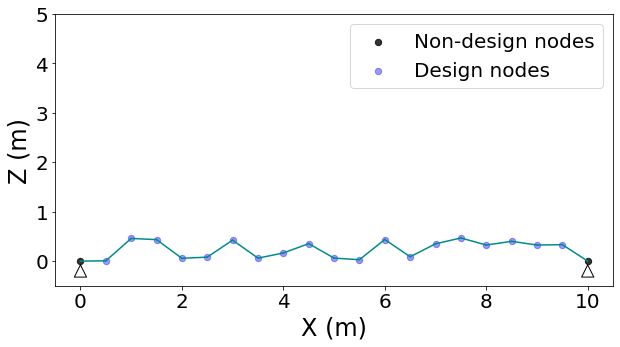

In [3]:
%matplotlib inline
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.tick_params(labelsize=20)
ax.set_ylim(-0.5,5)
ax.set_xlabel('X (m)',fontsize=24)
ax.set_ylabel('Z (m)',fontsize=24)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

plt.scatter(x_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',alpha=0.8,label='Non-design nodes',s=40)
plt.scatter(x_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2, s=150, facecolors='none', edgecolors='black',marker='^')
ax.scatter(x_nodes[design_nodes],z_nodes[design_nodes],color='blue',alpha=0.4,label='Design nodes',s=40)

plt.legend(fontsize=20, loc='best')
plt.show()

Define the objective function (with its gradient).

Create some lists/arrays to store the intermediate results.

In [4]:
params_store = [] #store parameters
f_store = [] #store the functional value 

In [5]:
def objective(x):
  params_store.append(x) #store params at each step
  z_nodes[design_nodes] = x #update the nodal coordiante

  ################
  #  SSO MODEL   #
  ################
  #Build the model
  sens_model = sso.Model_Sens.Model_Sens() #model for sensitivity analysis

  #Adding nodes and boundary conditions
  for i in range(n_node):
    
    sens_model.node(i,x_nodes[i],y_nodes[i],z_nodes[i])
    if i not in design_nodes:
      sens_model.add_support(i,[1,1,1,1,0,1]) #Pinned, only Ry allow

  #Adding elements
  for i in range(n_ele):
    i_node = cnct[i,0]
    j_node = cnct[i,1]
    sens_model.beamcol(i,i_node,j_node,E,G,Iy,Iz,J,A) 
  
  #Adding load
  sens_model.add_nodal_load(f)

  #Conduct FEA
  sens_model.solve()
  u_disp = sens_model.u #global displacement
  C = 0.5*f@u_disp #compliance of the system
  f_store.append(C) #store the compliance 
 

  ##################
  #  Gradient  #
  ##################
  #Get the sensitivity using SSO
  sens = sens_model.Sens_C_Coord(u_disp)
  z_dof_index = design_nodes*3+2 #index indicating the z-dof
  sens_params = sens[z_dof_index] #storing the sensitivity of obj. wrt design parameters
  return C,sens_params

# Perform the optimization

In [6]:
n_x = design_nodes.shape[0] #number of parameters
x_ini = z_nodes[design_nodes] #initial parameters 
opt = sso.Optimization.Optimization(n_x,method='GD')
opt.set_objective(objective) #objective function
opt.set_maxiter(150) #max iteration
opt.set_step_size(5e-2) #step size
x_opt = opt.optimize(x_ini,log=True)

c:\ProgramData\Anaconda3\lib\site-packages\jax\_src\numpy\lax_numpy.py:2306: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  start = asarray(start, dtype=computation_dtype)
c:\ProgramData\Anaconda3\lib\site-packages\jax\_src\numpy\lax_numpy.py:2307: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  stop = asarray(stop, dtype=computation_dtype)
c:\ProgramData\Anaconda3\lib\site-packages\jax\_src\numpy\lax_numpy.py:2323: UserWarning: Explicitly requested dtype float64 requested in as

Step 0, objective = 346.08904871468343
Step 1, objective = 508.22908415260645
Step 2, objective = 197.63748474856843
Step 3, objective = 45.56654922092291
Step 4, objective = 23.355336005792914
Step 5, objective = 15.24694203284039
Step 6, objective = 11.112314971165809
Step 7, objective = 8.844636144549098
Step 8, objective = 7.558228613797525
Step 9, objective = 6.794365851592257
Step 10, objective = 6.331125873154656
Step 11, objective = 6.04062442127723
Step 12, objective = 5.847025511491453
Step 13, objective = 5.720479058742297
Step 14, objective = 5.631826482403299
Step 15, objective = 5.57062188050865
Step 16, objective = 5.524107695173367
Step 17, objective = 5.492248331894288
Step 18, objective = 5.467738036926377
Step 19, objective = 5.449479473036545
Step 20, objective = 5.433237883154813
Step 21, objective = 5.424187516951476
Step 22, objective = 5.4137919473447225
Step 23, objective = 5.406391147463045
Step 24, objective = 5.400424851064526
Step 25, objective = 5.39599252

# Draw the final structure

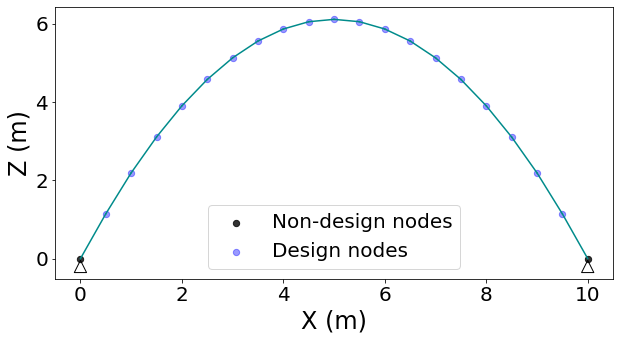

In [7]:
#Update the nodes
z_nodes[design_nodes] = x_opt
z_ele[:,0] = z_nodes[cnct[:,0]]
z_ele[:,1] = z_nodes[cnct[:,1]]

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.tick_params(labelsize=20)
#ax.set_ylim(-0.5,5)
ax.set_xlabel('X (m)',fontsize=24)
ax.set_ylabel('Z (m)',fontsize=24)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

plt.scatter(x_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',alpha=0.8,label='Non-design nodes',s=40)
plt.scatter(x_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2, s=150, facecolors='none', edgecolors='black',marker='^')
ax.scatter(x_nodes[design_nodes],z_nodes[design_nodes],color='blue',alpha=0.4,label='Design nodes',s=40)

plt.legend(fontsize=20, loc='best')
plt.show()